In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import yfinance as yf
from datetime import datetime, timedelta
import itertools
import warnings
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def _get_model_mse(symbol, start_date, end_date, interval, time_step, n_estimators, max_depth, learning_rate, subsample):
    """
    Helper function to train and evaluate the model, returning only the MSE.
    Designed for use within the optimization function to keep output clean.
    Returns None if data cannot be fetched or processed.
    """
    try:
        # Download data, focusing only on 'Close' price
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, prepost=True, progress=False)

        if data.empty or 'Close' not in data.columns:
            return None # No data or missing 'Close' column

        data = data[['Close']] # Use only the 'Close' price

        def create_dataset(data_df, time_step):
            X, y = [], []
            dates = []
            
            if len(data_df) <= time_step:
                return np.array([]), np.array([]), np.array([])

            data_values = data_df.values # Get the 'Close' prices as a numpy array

            for i in range(len(data_df) - time_step):
                # X contains a flattened window of historical 'Close' prices
                X.append(data_values[i:(i + time_step)].flatten())
                # y is the next 'Close' price
                y.append(data_values[i + time_step][0]) # [0] to get scalar from array
                dates.append(data_df.index[i + time_step])
            return np.array(X), np.array(y), np.array(dates)

        X, y, dates = create_dataset(data, time_step)

        if len(X) == 0:
            return None # Not enough data points to create sequences

        train_size = int(len(X) * 0.8) # Fixed 80/20 split for consistent evaluation
        if train_size == 0 or train_size >= len(X):
            return None # Not enough data for a valid train/test split

        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                     n_estimators=n_estimators, 
                                     max_depth=max_depth,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     random_state=42, 
                                     n_jobs=-1) # Use all cores
        
        xgb_model.fit(X_train, y_train)

        y_pred = xgb_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    except Exception as e:
        # print(f"Error in _get_model_mse: {e}") # Uncomment for debugging if needed
        return None

def analyze_stock_performance_intraday(symbol, start_date, end_date, interval='1h', time_step=60, n_estimators=100, random_state=42, test_size=0.2):
    """
    Analyzes stock performance using an XGBoost Regressor with intraday data,
    forecasting based solely on historical 'Close' prices.
    Captures pre-market and after-market hours if available for the given interval.
    """
    print(f"--- Analyzing {symbol} ({interval} interval) from {start_date} to {end_date} ---")

    try:
        data = yf.download(symbol, start=start_date, end=end_date, interval=interval, prepost=True)
        if data.empty or 'Close' not in data.columns:
            print(f"No data downloaded for {symbol} with interval {interval}. Check symbol, dates, interval.")
            return None, None
        data = data[['Close']] # Use only 'Close' price

        if interval in ['1m'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 7:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 7 days. Your requested range might be truncated.")
        elif interval in ['2m', '5m', '15m', '30m'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 60:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 60 days. Your requested range might be truncated.")
        elif interval in ['60m', '1h'] and (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days > 730:
            warnings.warn(f"WARNING: For interval '{interval}', yfinance typically provides data for only the last 730 days. Your requested range might be truncated.")

    except Exception as e:
        print(f"Error downloading data for {symbol} with interval {interval}: {e}")
        return None, None

    def create_dataset(data_df, time_step):
        X, y = [], []
        dates = []
        
        if len(data_df) <= time_step:
            return np.array([]), np.array([]), np.array([])

        data_values = data_df.values

        for i in range(len(data_df) - time_step):
            X.append(data_values[i:(i + time_step)].flatten())
            y.append(data_values[i + time_step][0])
            dates.append(data_df.index[i + time_step])
        return np.array(X), np.array(y), np.array(dates)

    X, y, dates = create_dataset(data, time_step)

    if len(X) == 0:
        print(f"Not enough data points ({len(data)} intervals) to create dataset with time_step={time_step}.")
        return None, None

    train_size = int(len(X) * (1 - test_size))
    if train_size == 0 or train_size >= len(X):
        print(f"Not enough data to create a valid train/test split with {len(X)} data points and test_size={test_size}.")
        return None, None

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = dates[:train_size], dates[train_size:]
    
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                                 n_estimators=n_estimators, 
                                 random_state=random_state,
                                 n_jobs=-1) # Use all cores
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {symbol} ({interval}): {mse:.4f}')

    return mse, (dates_test, y_test, y_pred)


## Optimize Stock Prediction (Close Price Only)
## This function will help you find the best parameters for your XGBoost model when predicting stock prices using only historical 'Close' price data. It performs a grid search over various intervals, time steps, and XGBoost hyperparameters.


def optimize_stock_prediction(symbol='INTU', past_days=50):
    """
    Optimizes XGBoost Regressor parameters for stock price prediction
    for a given symbol over a specified number of past days, using only
    historical 'Close' prices.
    """
    print(f"\n--- Starting optimization for {symbol} over the last {past_days} days ---")

    end_date = datetime.now()
    start_date = end_date - timedelta(days=past_days)

    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define the parameters to search over
    param_grid = {
        'interval': ['5m', '15m', '30m', '1h'], # Intervals for intraday data
        'time_step': [30, 60, 90],             # Number of past data points to consider for prediction
        'n_estimators': [50, 100, 150],        # Number of boosting rounds (trees)
        'max_depth': [3, 5, 7],                # Maximum depth of a tree
        'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
        'subsample': [0.7, 0.8, 0.9]           # Fraction of samples used for fitting trees
    }

    best_mse = float('inf')
    best_params = None

    keys = param_grid.keys()
    combinations = list(itertools.product(*param_grid.values()))

    total_combinations = len(combinations)
    print(f"Total combinations to test: {total_combinations}")

    for i, combo in enumerate(combinations):
        current_params = dict(zip(keys, combo))
        print(f"Testing combination {i+1}/{total_combinations}: {current_params}") # Progress indicator

        mse = _get_model_mse(
            symbol=symbol,
            start_date=start_date_str,
            end_date=end_date_str,
            interval=current_params['interval'],
            time_step=current_params['time_step'],
            n_estimators=current_params['n_estimators'],
            max_depth=current_params['max_depth'],
            learning_rate=current_params['learning_rate'],
            subsample=current_params['subsample']
        )

        if mse is not None and mse < best_mse:
            best_mse = mse
            best_params = current_params
            print(f"  --> New best MSE: {best_mse:.4f} with params: {best_params}")

    if best_params:
        print(f"\n--- Optimization Complete for {symbol} ---")
        print(f"Best Parameters: {best_params}")
        print(f"Lowest Mean Squared Error: {best_mse:.4f}")
        return {'best_params': best_params, 'best_mse': best_mse}
    else:
        print("\n--- Optimization Failed: No valid model could be trained with the given parameters and data. ---")
        return None


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477


--- Starting optimization for INTU over the last 60 days ---
Total combinations to test: 972
Testing combination 1/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 2/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 3/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 4/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 5/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 6/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 7/972: {'interval': '5m', 'time_step': 30, 'n_est


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 13/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 14/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 15/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 16/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 17/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 18/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 19/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 25/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 26/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 27/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 28/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 29/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 30/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 31/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 37/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 38/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 39/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 40/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 41/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 42/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 43/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 49/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 50/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 51/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 52/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 53/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 54/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 55/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing comb


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 61/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 62/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 63/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 64/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 65/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 66/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 67/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing co


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 73/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 74/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 75/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 76/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 77/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 78/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 79/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 85/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 86/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 87/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 88/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 89/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 90/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 91/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 97/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 98/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 99/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 100/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 101/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 102/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 103/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 109/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 110/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 111/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 112/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 113/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 114/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 115/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 122/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 123/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 124/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 125/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 126/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 127/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 128/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Test


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 134/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 135/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 136/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 137/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 138/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 139/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 140/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 145/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 146/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 147/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 148/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 149/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 150/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 151/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 157/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 158/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 159/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 160/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 161/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 162/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 163/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testin


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 169/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 170/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 171/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 172/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 173/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 174/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 175/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing co


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 181/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 182/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 183/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 184/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 185/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 186/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 187/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 193/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 194/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 195/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 196/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 197/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 198/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 199/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 205/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 206/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 207/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 208/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 209/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 210/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 211/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 217/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 218/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 219/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 220/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 221/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 222/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 223/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 229/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 230/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 231/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 232/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 233/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 234/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 235/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 241/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 242/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 243/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 244/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 245/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 246/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 247/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 253/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 254/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 255/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 256/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 257/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 258/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 259/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 265/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 266/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 267/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 268/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 269/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 270/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 271/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Test


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 277/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 278/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 279/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 280/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 281/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 282/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 283/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 289/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 290/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 291/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 292/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 293/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 294/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 295/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 301/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 302/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 303/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 304/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 305/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 306/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 307/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 313/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 314/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 315/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 316/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 317/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 318/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 319/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 325/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 326/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 327/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 328/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 329/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 330/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 331/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 337/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 338/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 339/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 340/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 341/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 342/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 343/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 349/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 350/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 351/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 352/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 353/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 354/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 355/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 361/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 362/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 363/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 364/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 365/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 366/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 367/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 373/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 374/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 375/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 376/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 377/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 378/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 379/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 385/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 386/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 387/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 388/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 389/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 390/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 391/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 397/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 398/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 399/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 400/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 401/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 402/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 403/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 409/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 410/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 411/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 412/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 413/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 414/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 415/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 421/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 422/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 423/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 424/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 425/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 426/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 427/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 433/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 434/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 435/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 436/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 437/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 438/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 439/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 445/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 446/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 447/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 448/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 449/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 450/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 451/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 457/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 458/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 459/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 460/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 461/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 462/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 463/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 469/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 470/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 471/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 472/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 473/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 474/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 475/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 481/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 482/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 483/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 484/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 485/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 486/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 487/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 493/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 494/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 495/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 496/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 497/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 498/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 499/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 505/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 506/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 507/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 508/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 509/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 510/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 511/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 517/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 518/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 519/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 520/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 521/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 522/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 523/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 530/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 531/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 532/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 533/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 534/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 535/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 536/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 542/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 543/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 544/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 545/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 546/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 547/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 548/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 554/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 555/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 556/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 557/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 558/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 559/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 560/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 566/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 567/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 568/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 569/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 570/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 571/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 572/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
T


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 577/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 578/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 579/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 580/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 581/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 582/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 583/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 589/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 590/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 591/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 592/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 593/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 594/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 595/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Test


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 602/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 603/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 604/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 605/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 606/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 607/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 608/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 614/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 615/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 616/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 617/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 618/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 619/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 620/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 626/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 627/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 628/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 629/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 630/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 631/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 632/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.

['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The r

Testing combination 639/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 640/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 641/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 642/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 643/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 644/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 645/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 651/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 652/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 653/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 654/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 655/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 656/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 657/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testi


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 663/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 664/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 665/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 666/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 667/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 668/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 669/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 675/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 676/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 677/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 678/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 679/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 680/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 681/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 687/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 688/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 689/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 690/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 691/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 692/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 693/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 698/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 699/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 700/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 701/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 702/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 703/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 704/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 710/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 711/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 712/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 713/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 714/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 715/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 716/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['INTU']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 722/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 723/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 724/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 725/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 726/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 727/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 728/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.

Testing combination 771/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 772/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 773/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 774/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 775/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 776/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 777/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes

Testing combination 827/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 828/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 829/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 830/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 831/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 832/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 833/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing co

Testing combination 883/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 884/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 885/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 886/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 887/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 888/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 889/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Tes

Testing combination 934/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 935/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 936/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 937/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 938/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 939/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 940/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Tes

[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for INTU ---
Best Parameters: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Lowest Mean Squared Error: 81.2624

--- Running best model for detailed analysis and plotting ---
--- Analyzing INTU (1h interval) from 2025-03-21 to 2025-05-20 ---
Mean Squared Error for INTU (1h): 86.8430



--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


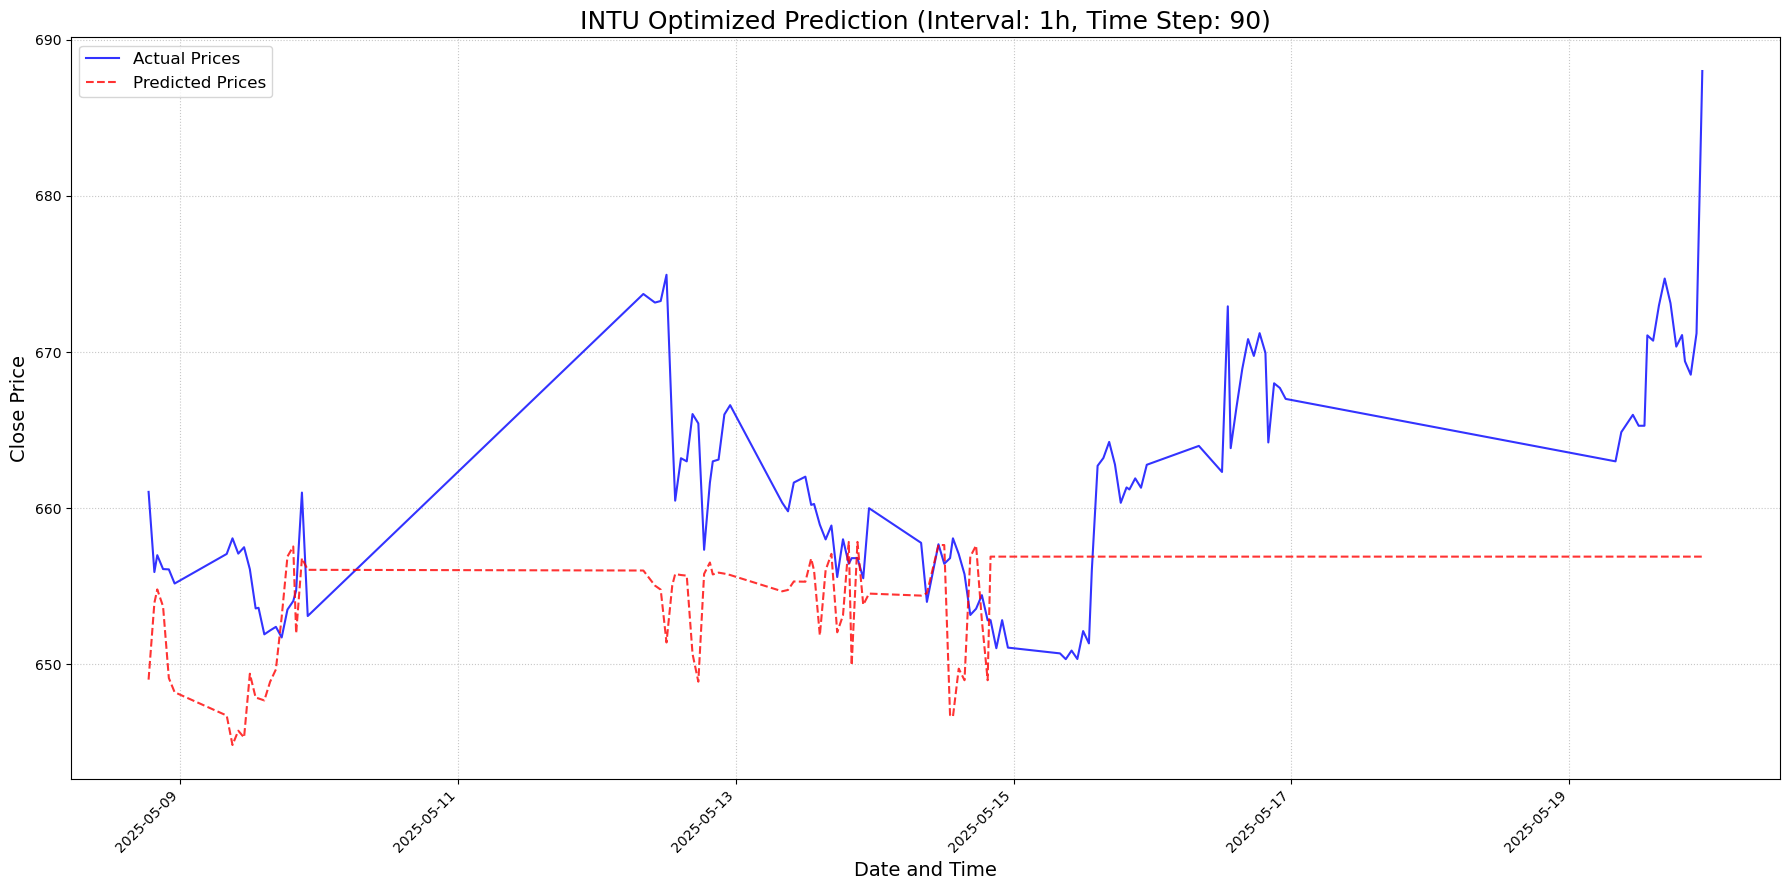

In [20]:
def plot_intraday_predictions_interactive(dates_test, y_test, y_pred, symbol, interval, mse, plot_title=None):
    """
    Generates an interactive plot for intraday price predictions, allowing for zooming and panning.
    """
    plt.figure(figsize=(18, 9))

    plt.plot(dates_test, y_test, label='Actual Prices', color='blue', linewidth=1.5, alpha=0.8)
    plt.plot(dates_test, y_pred, label='Predicted Prices', color='red', linestyle='--', linewidth=1.5, alpha=0.8)

    if plot_title:
        plt.title(plot_title, fontsize=18)
    else:
        plt.title(f'{symbol} Intraday Price Prediction ({interval} interval) - MSE: {mse:.4f}', fontsize=18)

    plt.xlabel('Date and Time', fontsize=14)
    plt.ylabel('Close Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    print("\n--- Interactive Plot Instructions ---")
    print("Use the toolbar at the bottom of the plot window:")
    print(" - Pan (hand icon): Click and drag to move the view around.")
    print(" - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.")
    print(" - Home (house icon): Reset view to original state.")
    print(" - Back/Forward (arrow icons): Navigate through view history.")
    print(" - Save (floppy disk icon): Save the current plot view.")

    plt.show()

# Example Usage:
if __name__ == "__main__":
    # Optimize parameters for a specific stock (e.g., 'INTU') over the last 60 days
    optimized_results = optimize_stock_prediction(symbol='INTU', past_days=60)

    if optimized_results:
        best_params = optimized_results['best_params']
        best_mse = optimized_results['best_mse']

        print("\n--- Running best model for detailed analysis and plotting ---")
        mse, plot_data = analyze_stock_performance_intraday(
            symbol='INTU',
            start_date=(datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d'),
            end_date=datetime.now().strftime('%Y-%m-%d'),
            interval=best_params['interval'],
            time_step=best_params['time_step'],
            n_estimators=best_params['n_estimators'],
            random_state=42 # Keep fixed for reproducibility
        )

        if plot_data:
            dates_test, y_test, y_pred = plot_data
            plot_intraday_predictions_interactive(dates_test, y_test, y_pred, 'INTU', best_params['interval'], mse,
                                                  f'INTU Optimized Prediction (Interval: {best_params["interval"]}, Time Step: {best_params["time_step"]})')


--- Starting optimization for AAPL over the last 60 days ---
Total combinations to test: 972
Testing combination 1/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}



1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 2/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 3/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 4/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 5/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 6/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 7/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 8/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 9/972


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 14/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 15/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 16/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 17/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 18/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 19/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 20/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combinatio


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 26/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 27/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 28/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 29/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 30/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 31/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 32/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing comb


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 37/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 38/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 39/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 40/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 41/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 42/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 43/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 49/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 50/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 51/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 52/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 53/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 54/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 55/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing comb


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 62/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 63/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 64/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 65/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 66/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 67/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 68/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing co


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 74/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 75/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 76/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 77/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 78/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 79/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 80/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing com


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 87/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 88/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 89/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 90/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 91/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 92/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 93/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combinati


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 100/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 101/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 102/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 103/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 104/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 105/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 106/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 110/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 111/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 112/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 113/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 114/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 115/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 116/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 123/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 124/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 125/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 126/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 127/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 128/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 129/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 135/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 136/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 137/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 138/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 139/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 140/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 141/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 146/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 147/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 148/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 149/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 150/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 151/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 152/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 159/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 160/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 161/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 162/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 163/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 164/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 165/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testin


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 171/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 172/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 173/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 174/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 175/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 176/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 177/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing co


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 183/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 184/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 185/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 186/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 187/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 188/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 189/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing comb


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 193/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 194/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 195/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 196/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 197/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 198/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 199/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 208/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 209/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 210/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 211/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 212/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 213/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 214/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 220/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 221/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 222/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 223/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 224/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 225/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 226/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 233/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 234/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 235/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 236/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 237/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 238/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 239/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 245/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 246/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 247/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 248/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 249/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 250/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 251/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 257/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 258/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 259/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 260/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 261/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 262/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 263/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Test


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 270/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 271/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 272/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 273/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 274/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 275/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 276/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 282/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 283/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 284/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 285/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 286/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 287/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 288/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 294/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 295/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 296/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 297/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 298/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 299/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 300/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 306/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 307/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 308/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 309/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 310/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 311/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 312/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 318/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 319/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 320/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 321/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 322/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 323/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 324/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 330/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 331/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 332/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 333/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 334/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 335/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 336/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 341/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 342/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 343/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 344/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 345/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 346/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 347/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 353/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 354/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 355/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 356/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 357/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 358/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 359/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 365/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 366/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 367/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 368/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 369/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 370/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 371/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 377/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 378/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 379/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 380/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 381/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 382/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 383/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 389/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 390/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 391/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 392/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 393/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 394/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 395/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 401/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 402/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 403/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 404/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 405/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 406/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 407/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 413/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 414/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 415/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 416/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 417/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 418/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 419/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 425/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 426/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 427/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 428/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 429/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 430/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 431/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 438/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 439/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 440/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 441/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 442/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 443/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 444/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 450/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 451/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 452/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 453/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 454/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 455/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 456/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 463/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 464/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 465/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 466/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 467/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 468/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 469/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 475/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 476/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 477/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 478/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 479/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 480/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 481/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 487/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 488/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 489/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 490/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 491/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 492/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 493/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 499/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 500/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 501/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 502/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 503/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 504/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 505/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 511/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 512/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 513/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 514/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 515/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 516/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 517/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 523/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 524/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 525/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 526/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 527/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 528/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 529/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 535/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 536/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 537/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 538/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 539/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 540/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 541/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 547/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 548/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 549/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 550/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 551/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 552/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 553/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 559/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 560/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 561/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 562/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 563/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 564/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 565/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 571/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 572/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 573/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 574/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 575/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 576/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 577/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 582/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 583/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 584/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 585/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 586/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 587/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 588/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 594/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 595/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 596/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 597/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 598/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 599/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 600/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 608/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 609/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 610/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 611/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 612/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 613/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 614/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 620/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 621/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 622/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 623/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 624/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 625/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 626/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 632/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 633/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 634/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 635/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 636/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 637/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 638/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 643/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 644/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 645/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 646/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 647/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 648/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 649/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 655/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 656/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 657/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 658/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 659/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 660/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 661/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 667/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 668/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 669/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 670/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 671/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 672/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 673/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 679/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 680/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 681/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 682/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 683/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 684/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 685/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 690/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 691/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 692/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 693/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 694/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 695/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 696/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 702/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 703/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 704/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 705/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 706/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 707/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 708/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 714/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 715/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 716/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 717/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 718/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 719/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 720/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 726/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 727/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 728/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 729/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 730/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
  --> New best MSE: 18.3964 with params: {'interval': '1h', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 731/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsamp

Testing combination 782/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 783/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 784/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 785/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 786/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 787/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 788/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Tes

Testing combination 841/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 842/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 843/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 844/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 845/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 846/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 847/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi

Testing combination 899/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
  --> New best MSE: 1.3597 with params: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 900/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 901/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 902/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 903/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 904/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}

Testing combination 956/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 957/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 958/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 959/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 960/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 961/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 962/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Test

[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for AAPL ---
Best Parameters: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Lowest Mean Squared Error: 1.3597

--- Running best model for detailed analysis and plotting ---
--- Analyzing AAPL (1h interval) from 2025-03-21 to 2025-05-20 ---
Mean Squared Error for AAPL (1h): 1.9283

--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


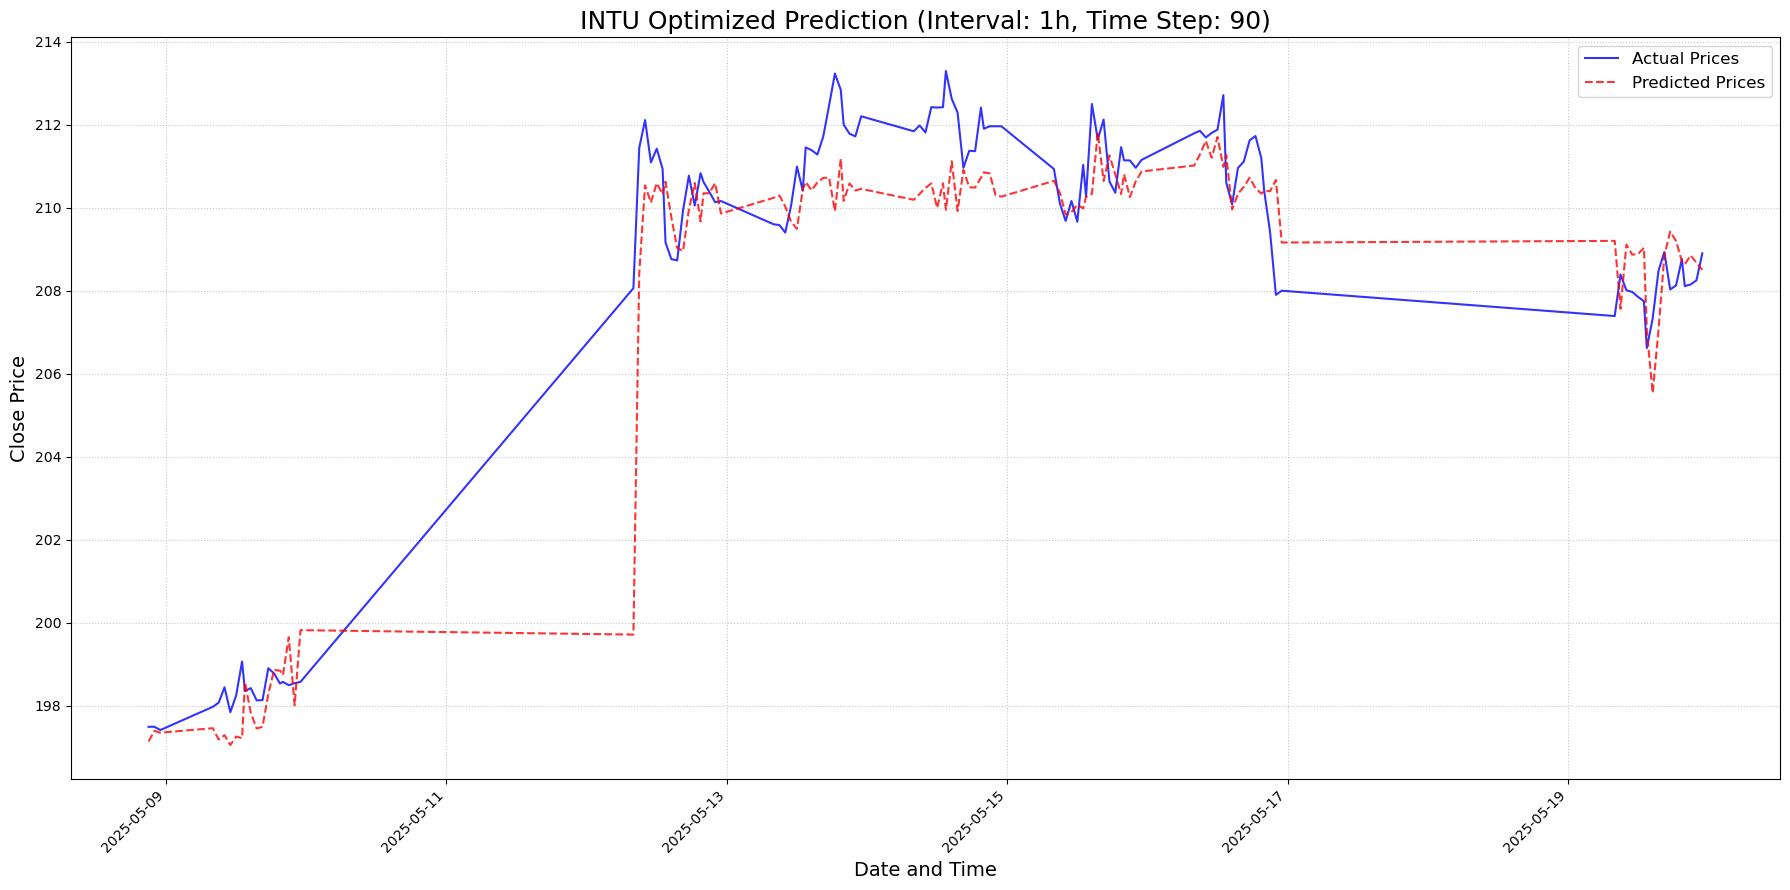

In [21]:
if __name__ == "__main__":
  

    optimized_results = optimize_stock_prediction(symbol='AAPL', past_days=60)

    if optimized_results:
        best_params = optimized_results['best_params']
        best_mse = optimized_results['best_mse']

        print("\n--- Running best model for detailed analysis and plotting ---")
        mse, plot_data = analyze_stock_performance_intraday(
            symbol='AAPL',
            start_date=(datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d'),
            end_date=datetime.now().strftime('%Y-%m-%d'),
            interval=best_params['interval'],
            time_step=best_params['time_step'],
            n_estimators=best_params['n_estimators'],
            random_state=42 # Keep fixed for reproducibility
        )

        if plot_data:
            dates_test, y_test, y_pred = plot_data
            plot_intraday_predictions_interactive(dates_test, y_test, y_pred, 'AAPL', best_params['interval'], mse,
                                                  f'INTU Optimized Prediction (Interval: {best_params["interval"]}, Time Step: {best_params["time_step"]})')


--- Starting optimization for TSLA over the last 60 days ---
Total combinations to test: 972
Testing combination 1/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}



1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 2/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 3/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 4/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 5/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 6/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 7/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 8/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 9/972


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 14/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 15/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 16/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 17/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 18/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 19/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 20/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combinatio


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 26/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 27/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 28/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 29/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 30/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 31/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 32/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing comb


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 38/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 39/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 40/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 41/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 42/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 43/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 44/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing com


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 49/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 50/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 51/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 52/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 53/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 54/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 55/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing comb


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 60/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 61/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 62/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 63/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 64/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 65/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 66/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing co


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 72/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 73/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 74/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 75/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 76/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 77/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 78/972: {'interval': '5m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing co


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 84/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 85/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 86/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 87/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 88/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 89/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 90/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 96/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 97/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 98/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 99/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 100/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 101/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 102/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combin


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 108/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 109/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 110/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 111/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 112/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 113/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 114/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Test

['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested

Testing combination 120/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 121/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 122/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 123/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 124/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 125/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 126/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testi


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 132/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 133/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 134/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 135/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 136/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 137/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 138/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Tes

['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested

Testing combination 143/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 144/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 145/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 146/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 147/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 148/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 149/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 155/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 156/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 157/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 158/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 159/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 160/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 161/972: {'interval': '5m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 166/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 167/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 168/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 169/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 170/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 171/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 172/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing comb


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 178/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 179/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 180/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 181/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 182/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 183/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 184/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing co


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 190/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 191/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 192/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 193/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 194/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 195/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 196/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 202/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 203/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 204/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 205/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 206/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 207/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 208/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 214/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 215/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 216/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 217/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 218/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 219/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 220/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 226/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 227/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 228/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 229/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 230/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 231/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 232/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (5m 2025-03-21 -> 2025-05-20) (Yahoo error = "5m data not available for startTime=1742529600 and endTime=17477

Testing combination 238/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 239/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 240/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 241/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 242/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 243/972: {'interval': '5m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 244/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}



1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 245/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 246/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 247/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 248/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 249/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 250/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 251/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Test


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 257/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 258/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 259/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 260/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 261/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 262/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 263/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Test


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 269/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 270/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 271/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 272/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 273/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 274/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 275/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 282/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 283/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 284/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 285/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 286/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 287/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 288/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 295/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 296/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 297/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 298/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 299/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 300/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 301/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 307/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 308/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 309/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 310/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 311/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 312/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 313/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 319/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 320/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 321/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 322/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 323/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 324/972: {'interval': '15m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 325/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 331/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 332/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 333/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 334/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 335/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 336/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 337/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 343/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 344/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 345/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 346/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 347/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 348/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 349/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 355/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 356/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 357/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 358/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 359/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 360/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 361/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 367/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 368/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 369/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 370/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 371/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 372/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 373/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 379/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 380/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 381/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 382/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 383/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 384/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 385/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 391/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 392/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 393/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 394/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 395/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 396/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 397/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 403/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 404/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 405/972: {'interval': '15m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 406/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 407/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 408/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 409/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}



1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 414/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 415/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 416/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 417/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 418/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 419/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 420/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 426/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 427/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 428/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 429/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 430/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 431/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 432/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testi

['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The r

Testing combination 437/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 438/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 439/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 440/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 441/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 442/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 443/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 450/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 451/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 452/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 453/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 454/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 455/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 456/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 462/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 463/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 464/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 465/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 466/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 467/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 468/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 474/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 475/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 476/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 477/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 478/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 479/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 480/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 486/972: {'interval': '15m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 487/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 488/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 489/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 490/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 491/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 492/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Te


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 498/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 499/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 500/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 501/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 502/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 503/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 504/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testi


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 510/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 511/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 512/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 513/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 514/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 515/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 516/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}



1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 522/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 523/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 524/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 525/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 526/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 527/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 528/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 534/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 535/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 536/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 537/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 538/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 539/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 540/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 546/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 547/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 548/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 549/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 550/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 551/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 552/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 558/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 559/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 560/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 561/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 562/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 563/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 564/972: {'interval': '30m', 'time_step': 30, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 570/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 571/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 572/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 573/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 574/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 575/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 576/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testi


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 582/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 583/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 584/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 585/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 586/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 587/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 588/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 594/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 595/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 596/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 597/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 598/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 599/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 600/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.

['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The r

Testing combination 605/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 606/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 607/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 608/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 609/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 610/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 611/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.

['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The r

Testing combination 616/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 617/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 618/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 619/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 620/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 621/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 622/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 628/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 629/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 630/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 631/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 632/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 633/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 634/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 640/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 641/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 642/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 643/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 644/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 645/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 646/972: {'interval': '30m', 'time_step': 60, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 652/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 653/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 654/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 655/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 656/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 657/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 658/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testi


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 663/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 664/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 665/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 666/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 667/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 668/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 669/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Tes


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 675/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 676/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 677/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 678/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 679/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 680/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 681/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 686/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 687/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 688/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 689/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 690/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 691/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 692/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'subsample': 0.


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 698/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 699/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 700/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 701/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 702/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 703/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 704/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 710/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 711/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 712/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 713/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 714/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 715/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 716/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0


1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTime=1747713600. The requested range must be within the last 60 days.")')

1 Failed download:
['TSLA']: YFPricesMissingError('possibly delisted; no price data found  (15m 2025-03-21 -> 2025-05-20) (Yahoo error = "15m data not available for startTime=1742529600 and endTi

Testing combination 722/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 723/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 724/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 725/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 726/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 727/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 728/972: {'interval': '30m', 'time_step': 90, 'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.

Testing combination 776/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 777/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 778/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 779/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 780/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 781/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 782/972: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Test

Testing combination 834/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 835/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 836/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 837/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 838/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 839/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 840/972: {'interval': '1h', 'time_step': 60, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing

Testing combination 892/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 893/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.8}
Testing combination 894/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.9}
Testing combination 895/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7}
Testing combination 896/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 897/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 898/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing co

Testing combination 950/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Testing combination 951/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.9}
Testing combination 952/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.7}
Testing combination 953/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.8}
Testing combination 954/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.9}
Testing combination 955/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.7}
Testing combination 956/972: {'interval': '1h', 'time_step': 90, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.8}
Test

[*********************100%***********************]  1 of 1 completed


--- Optimization Complete for TSLA ---
Best Parameters: {'interval': '1h', 'time_step': 30, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8}
Lowest Mean Squared Error: 1891.7657

--- Running best model for detailed analysis and plotting ---
--- Analyzing TSLA (1h interval) from 2025-03-21 to 2025-05-20 ---
Mean Squared Error for TSLA (1h): 2182.2508

--- Interactive Plot Instructions ---
Use the toolbar at the bottom of the plot window:
 - Pan (hand icon): Click and drag to move the view around.
 - Zoom (magnifying glass icon): Click and drag to define a zoom rectangle.
 - Home (house icon): Reset view to original state.
 - Back/Forward (arrow icons): Navigate through view history.
 - Save (floppy disk icon): Save the current plot view.


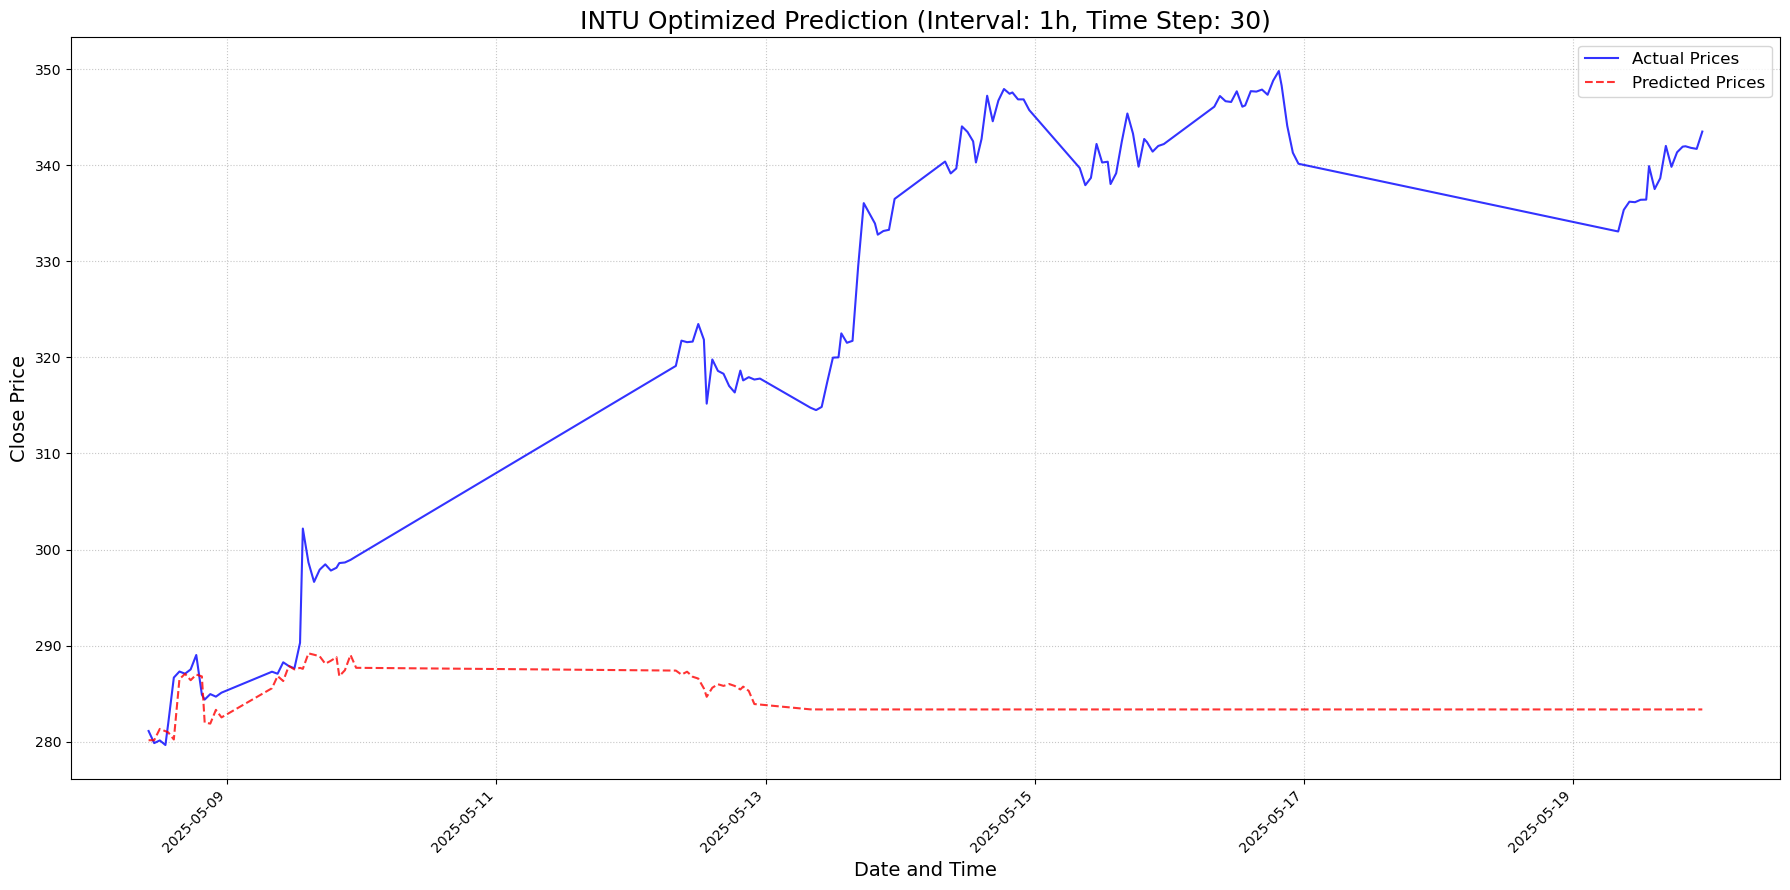

In [22]:
if __name__ == "__main__":
    
    
    optimized_results = optimize_stock_prediction(symbol='TSLA', past_days=60)

    if optimized_results:
        best_params = optimized_results['best_params']
        best_mse = optimized_results['best_mse']

        print("\n--- Running best model for detailed analysis and plotting ---")
        mse, plot_data = analyze_stock_performance_intraday(
            symbol='TSLA',
            start_date=(datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d'),
            end_date=datetime.now().strftime('%Y-%m-%d'),
            interval=best_params['interval'],
            time_step=best_params['time_step'],
            n_estimators=best_params['n_estimators'],
            random_state=42 # Keep fixed for reproducibility
        )

        if plot_data:
            dates_test, y_test, y_pred = plot_data
            plot_intraday_predictions_interactive(dates_test, y_test, y_pred, 'TSLA', best_params['interval'], mse,
                                                  f'INTU Optimized Prediction (Interval: {best_params["interval"]}, Time Step: {best_params["time_step"]})')